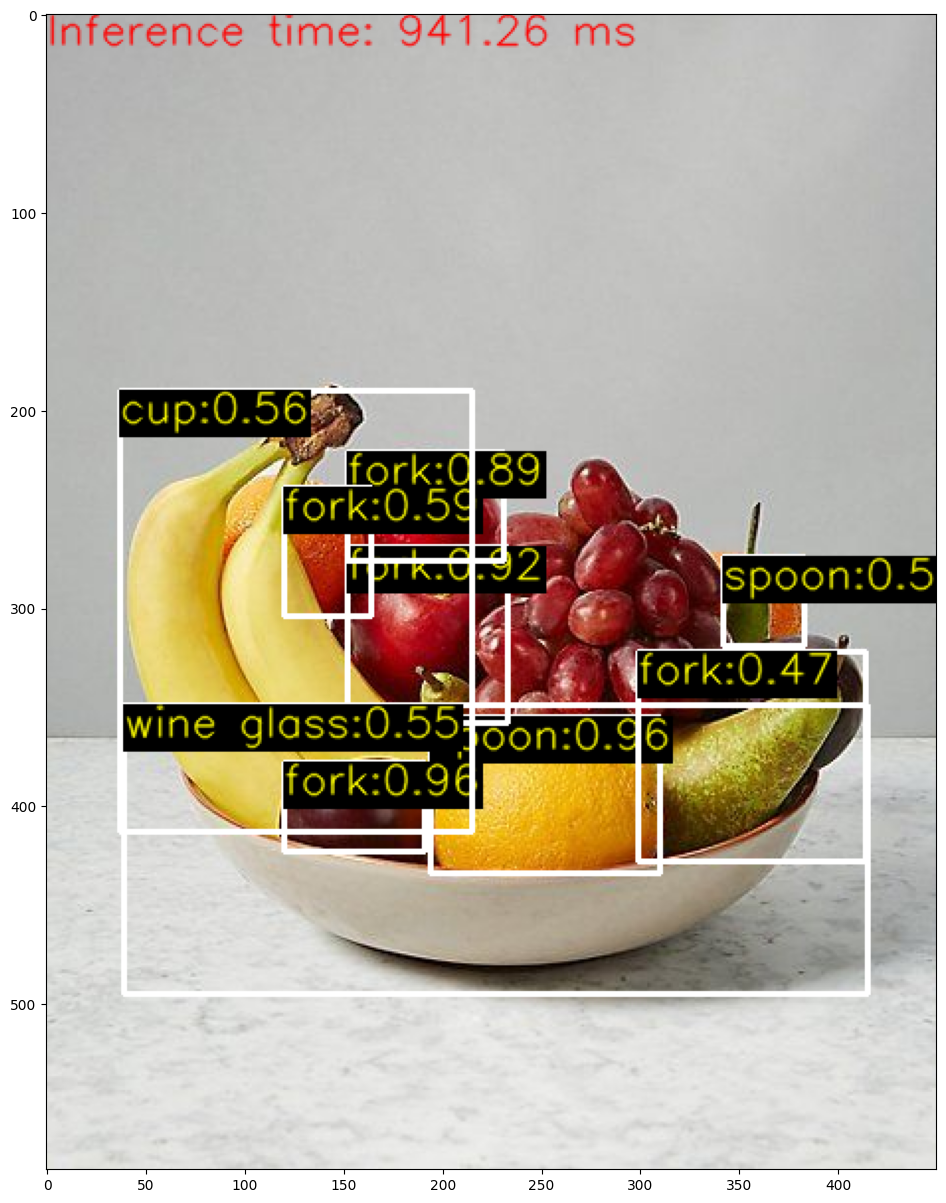

Inference time: 941.26 ms


In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import sys
import requests
import os
from os import path

plt.rcParams['figure.figsize'] = (15.0, 15.0)
plt.rcParams['image.cmap'] = 'gray'
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 14

# Parâmetros
objectnessThreshold = 0.3
confThreshold = 0.4
nmsThreshold = 0.4
inpWidth = 608
inpHeight = 608

# Caminhos
imagePath = "images/frutas.jpg"
classesFile = "resources/object_detection_classes_coco.txt"
modelConfiguration = "resources/yolov4.cfg"
modelWeights = "resources/yolov4.weights"
tiny_modelConfiguration = "resources/yolov4-tiny.cfg"
tiny_modelWeights = "resources/yolov4-tiny.weights"

# Carregar classes
with open(classesFile, 'rt') as f:
    classes = f.read().rstrip('\n').split('\n')

# Carregar modelo
net = cv2.dnn.readNetFromDarknet(modelConfiguration, modelWeights)

# Função para pegar camadas de saída
def getOutputsNames(net):
    layersNames = net.getLayerNames()
    return [layersNames[i - 1] for i in net.getUnconnectedOutLayers()]

# Estilo do texto
FONTFACE = cv2.FONT_HERSHEY_SIMPLEX
FONT_SCALE = 0.7
THICKNESS = 1

def display_text(im, text, x, y):
    textSize = cv2.getTextSize(text, FONTFACE, FONT_SCALE, THICKNESS)[0]
    baseline = cv2.getTextSize(text, FONTFACE, FONT_SCALE, THICKNESS)[1]
    cv2.rectangle(im, (x, y), (x + textSize[0], y + textSize[1] + baseline), (0, 0, 0), cv2.FILLED)
    cv2.putText(im, text, (x, y + textSize[1]), FONTFACE, FONT_SCALE, (0, 255, 255), THICKNESS, cv2.LINE_AA)

def display_objects(frame, outs):
    frameHeight, frameWidth = frame.shape[:2]
    classIds = []
    confidences = []
    boxes = []

    for out in outs:
        for detection in out:
            if detection[4] > objectnessThreshold:
                scores = detection[5:]
                classId = np.argmax(scores)
                confidence = scores[classId]
                if confidence > confThreshold:
                    center_x = int(detection[0] * frameWidth)
                    center_y = int(detection[1] * frameHeight)
                    width = int(detection[2] * frameWidth)
                    height = int(detection[3] * frameHeight)
                    left = int(center_x - width / 2)
                    top = int(center_y - height / 2)
                    classIds.append(classId)
                    confidences.append(float(confidence))
                    boxes.append([left, top, width, height])

    indices = cv2.dnn.NMSBoxes(boxes, confidences, confThreshold, nmsThreshold)
    for i in indices:
        i = i[0] if isinstance(i, (list, tuple, np.ndarray)) else i
        box = boxes[i]
        left, top, width, height = box
        cv2.rectangle(frame, (left, top), (left + width, top + height), (255, 255, 255), 2)
        label = f"{classes[classIds[i]]}:{confidences[i]:.2f}"
        display_text(frame, label, left, top)

# Carregar imagem
frame = cv2.imread(imagePath)
blob = cv2.dnn.blobFromImage(frame, 1/255, (inpWidth, inpHeight), [0, 0, 0], 1, crop=False)
net.setInput(blob)

# Inferência e exibição
outs = net.forward(getOutputsNames(net))
display_objects(frame, outs)

t, _ = net.getPerfProfile()
label = 'Inference time: %.2f ms' % (t * 1000.0 / cv2.getTickFrequency())
cv2.putText(frame, label, (0, 15), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 1, cv2.LINE_AA)
plt.imshow(frame[..., ::-1])
plt.show()
print(label)
